In [1]:
import os
import sys
import time
import random
import numpy as np
from tqdm import tqdm
import torch
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

from density_decoding.utils.utils import set_seed, to_device
from density_decoding.utils.data_utils import (
    IBLDataLoader,
    initilize_gaussian_mixtures,
    initialize_weight_matrix
)
from density_decoding.models.glm import train_glm
from density_decoding.models.advi import (
    ModelDataLoader, 
    ADVI,
    train_advi,
    compute_posterior_weight_matrix
)
from density_decoding.decoders.behavior_decoder import generic_decoder, sliding_window_decoder

seed = 666
set_seed(seed)

device = torch.device("cpu")

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 12.5
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

#### continuous behaviors

In [3]:
def load_data_from_h5(path, file_name):
    import h5py
    file_path = Path(path)/file_name
    with h5py.File(file_path, "r") as h5:
        spike_times = h5["times_samples"][:]
        spike_channels = h5["channels"][:]
        spike_amps = h5["denoised_ptp_amplitudes"][:]
        x, _, z, _ = h5["point_source_localizations"][:].T
    spike_features = np.c_[x, z, spike_amps]
    return spike_times, spike_channels, spike_features

In [4]:
pid = "c4f6665f-8be5-476b-a6e8-d81eeae9279d"

path = "/u/yzhang39/density_decoding/data/"
file_name = f"{pid}_feats.h5"
spike_times, spike_channels, spike_features = load_data_from_h5(path, file_name)

In [5]:
ibl_data_loader = IBLDataLoader(
    pid, 
    n_t_bins = 30
)

/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2024-05-06"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


pulling data from ibl database ..
eid: e535fb62-e245-4a48-b119-88ce62a6fe67
pid: c4f6665f-8be5-476b-a6e8-d81eeae9279d
number of trials found: 385 (active: 385)


/u/yzhang39/miniconda3/envs/density_decoding/lib/python3.11/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


prior for this session is not found.
found 385 trials from 11.28 to 2391.34 sec.


In [6]:
wheel_speed = ibl_data_loader.process_behaviors("wheel_speed")
wheel_speed = normalize(wheel_speed)

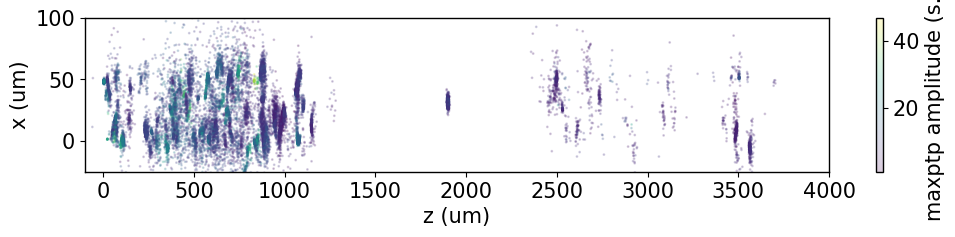

In [7]:
n_spikes_display = 2_0000
x, z, maxptp = spike_features[:n_spikes_display].T

fig, ax = plt.subplots(1, 1, figsize=(12,2))
im = ax.scatter(z, x, c=maxptp, s=1, alpha=.2)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim(-100, 4000)
ax.set_ylim(-25, 100)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
cbar.set_label("maxptp amplitude (s.u.)")
plt.show()

In [11]:
brain_region = "ca1"

In [12]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 56 channels in region ca1


Process spike features: 100%|██████████| 385/385 [00:00<00:00, 505.80it/s]


found 56 channels in region ca1


Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 8940.31it/s]


found 106 Kilosort units in region ca1


Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 8845.11it/s]


found 4 good units in region ca1


Compute spike count: 100%|██████████| 385/385 [00:00<00:00, 30709.09it/s]


In [13]:
trial_idxs = np.arange(ibl_data_loader.n_trials)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

In [14]:
spike_features = np.concatenate([
    np.concatenate([
        features for features in trial_features if len(features) > 0
    ]) for trial_features in bin_spike_features if len(trial_features) > 0
])
gmm = initilize_gaussian_mixtures(
    spike_features=spike_features[:,1:], 
    spike_channels=spike_features[:,0], 
    method="isosplit", 
    verbose=False,
)
n_t = ibl_data_loader.n_t_bins
n_c = gmm.means_.shape[0]
n_d = gmm.means_.shape[1]
print(f"Initialized a mixture with {n_c} components.")

init_weight_matrix = initialize_weight_matrix(
    gmm,
    bin_spike_features, 
)

Initialize GMM: 100%|██████████| 42/42 [00:01<00:00, 39.54it/s]


Initialized a mixture with 47 components.


Initialize weight matrix: 100%|██████████| 385/385 [00:06<00:00, 61.63it/s]


In [15]:
model_data_loader = ModelDataLoader(
    bin_spike_features,
    wheel_speed,
    bin_trial_idxs,
    bin_time_idxs
)

train_spike_features, train_trial_idxs, train_time_idxs, \
    test_spike_features, test_trial_idxs, test_time_idxs = \
        model_data_loader.split_train_test(train, test)

In [16]:
glm, losses = train_glm(
    X = init_weight_matrix, 
    Y = wheel_speed, 
    train = train,
    test = test,
    learning_rate = 1e-3,
    n_epochs = 5000
)

Train GLM:: 100%|██████████| 5000/5000 [00:22<00:00, 222.42it/s]


In [17]:
batch_size = 32
batch_idxs = list(zip(*(iter(train),) * batch_size))

advi = ADVI(
    n_r = 2,
    n_t = n_t, 
    gmm = gmm, 
    U_prior = glm.U.detach(),
    V_prior = glm.V.detach(),
    b_prior = glm.b.detach(),
    device = device
)

elbos = train_advi(
    advi,
    spike_features = to_device(train_spike_features[:,1:], device), 
    behaviors = to_device(model_data_loader.bin_behaviors, device), 
    trial_idxs = to_device(train_trial_idxs, device), 
    time_idxs = to_device(train_time_idxs, device), 
    batch_idxs= batch_idxs, 
    optim = torch.optim.Adam(advi.parameters(), lr=1e-3, weight_decay=1e-3),
    max_iter=5000,
)

Train ADVI: 100%|██████████| 5000/5000 [09:33<00:00,  8.72it/s]


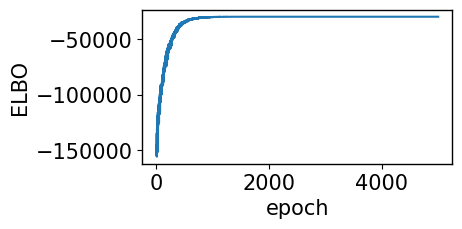

In [18]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("epoch")
plt.ylabel("ELBO");

In [19]:
y_train, y_test, y_pred, _ = generic_decoder(
    init_weight_matrix, 
    wheel_speed, train, test, 
    behavior_type="continuous", penalty_strength=1e3, seed=seed
)

post_params = {
    "b": advi.b.loc.detach().numpy(),
    "U": advi.U.loc.detach().numpy(),
    "V": advi.V.loc.detach().numpy(),
    "beta": advi.U.loc.detach().numpy() @ advi.V.loc.detach().numpy(),
    "means": advi.means.detach().numpy(),
    "covs": advi.covs.detach().numpy(),
}

mixture_weights, weight_matrix, firing_rates = compute_posterior_weight_matrix(
    bin_spike_features, y_train, y_pred, train, test, post_params, n_workers=1
)

Compute weight matrix: 100%|██████████| 385/385 [00:07<00:00, 53.24it/s]


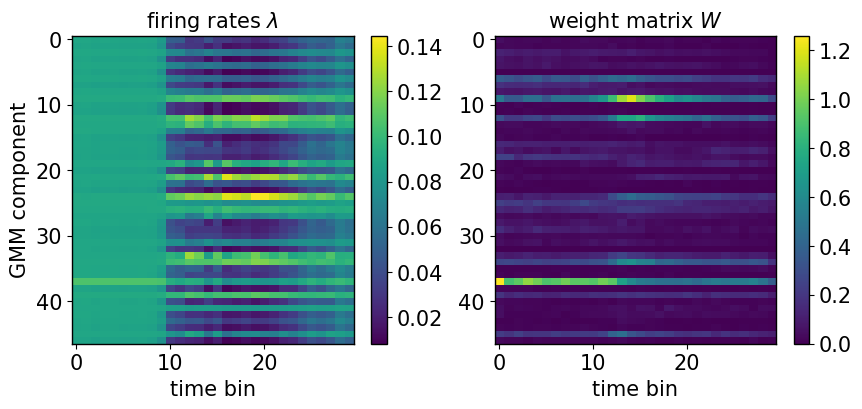

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
im1 = ax1.imshow(firing_rates.mean(0), aspect="auto")
im2 = ax2.imshow(weight_matrix.mean(0), aspect="auto")
cbar = plt.colorbar(im1, ax=ax1)
cbar = plt.colorbar(im2, ax=ax2)
ax1.set_xlabel("time bin")
ax2.set_xlabel("time bin")
ax1.set_ylabel("GMM component")
ax1.set_title(r"firing rates $\lambda$")
ax2.set_title(r"weight matrix $W$");

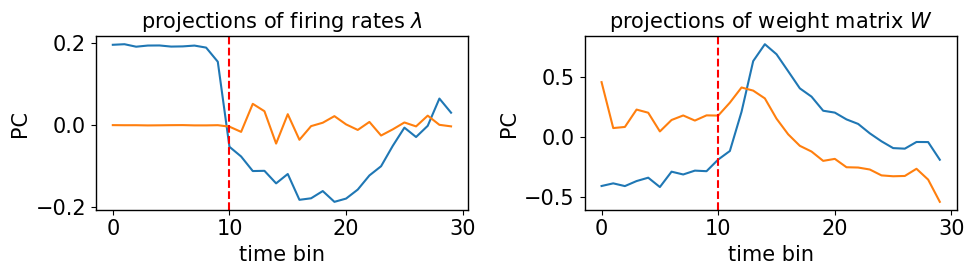

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
pca = PCA(n_components=2)
pca.fit(firing_rates.mean(0).T)
fr_proj = pca.transform(firing_rates.mean(0).T)
ax1.plot(fr_proj)
ax1.axvline(x=10, c="r", linestyle="--")
ax1.set_xlabel("time bin")
ax1.set_ylabel("PC")
ax1.set_title(r"projections of firing rates $\lambda$")

pca.fit(weight_matrix.mean(0).T)
w_proj = pca.transform(weight_matrix.mean(0).T)
ax2.plot(w_proj)
ax2.axvline(x=10, c="r", linestyle="--")
ax2.set_xlabel("time bin")
ax2.set_ylabel("PC")
ax2.set_title(r"projections of weight matrix $W$")

plt.tight_layout()

In [23]:
_, y_test, density_pred, metrics = sliding_window_decoder(
    weight_matrix, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.200, MSE: 0.017, Corr: 0.448


In [24]:
_, y_test, ks_pred, metrics = sliding_window_decoder(
    all_sorted_spike_count, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.117, MSE: 0.018, Corr: 0.343


In [25]:
_, _, _, _ = sliding_window_decoder(
    good_sorted_spike_count, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.026, MSE: 0.020, Corr: 0.162


In [26]:
_, _, _, _ = sliding_window_decoder(
    thresholded_spike_count, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.114, MSE: 0.018, Corr: 0.339


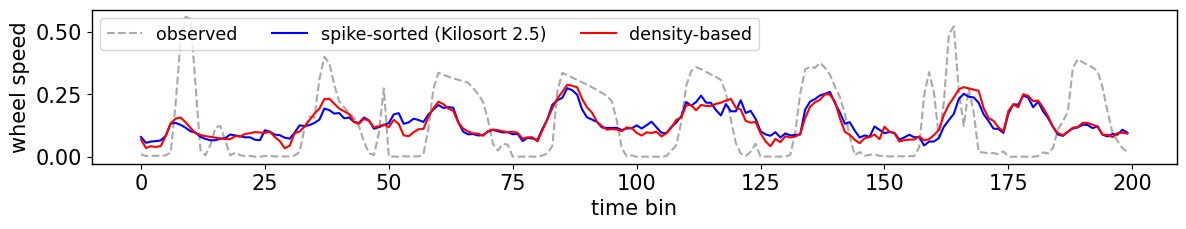

In [27]:
plt.figure(figsize=(14,2))
plt.plot(y_test[:200], c="darkgray", linestyle="--", label="observed")
plt.plot(ks_pred[:200], c="blue", linestyle="-", label="spike-sorted (Kilosort 2.5)")
plt.plot(density_pred[:200], c="red", linestyle="-", label="density-based")
plt.xlabel("time bin")
plt.ylabel("wheel speed")
plt.legend(ncol=3, loc="upper left")
plt.show()